In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from pathlib import Path

In [2]:
pudl_sqlite_path = Path("../data/data_cache/pudl/v2024.2.6/pudl.sqlite")
pudl_engine = create_engine(f"sqlite:////{pudl_sqlite_path.absolute()}")

### What kinds of statuses exist in this dataset?

In [16]:
# most recent data
pd.read_sql("select max(valid_until_date) from core_eia860m__changelog_generators", pudl_engine)

,max(valid_until_date)
0,2023-12-01


In [13]:
query = """
SELECT
    operational_status,
    operational_status_code,
    count(plant_id_eia) as n_plants,
    count(distinct plant_id_eia) as n_unique_plants,
    count(generator_id) as n_generators,
    -- count(distinct (plant_id_eia, generator_id)) as n_unique_generators, -- postgres syntax
    count(distinct cast(plant_id_eia as text) || '|' || generator_id) as n_unique_generators, -- sqlite syntax
    sum(capacity_mw) as total_capacity_mw
FROM core_eia860m__changelog_generators
WHERE valid_until_date = '2023-12-01'  -- most recent data
GROUP BY 1, 2
ORDER BY 1, 2
"""
statuses = pd.read_sql(query, pudl_engine)
statuses

,operational_status,operational_status_code,n_plants,n_unique_plants,n_generators,n_unique_generators,total_capacity_mw
0,existing,OA,313,180,313,313,10881.6
1,existing,OP,23334,11646,23334,23334,1241531.0
2,existing,OS,487,282,487,487,8526.6
3,existing,SB,1614,492,1614,1614,9972.6
4,proposed,L,226,176,226,226,36427.6
5,proposed,OT,1,1,1,1,25.5
6,proposed,P,416,306,416,416,48578.5
7,proposed,T,161,136,161,161,22740.5
8,proposed,TS,134,117,134,134,6272.4
9,proposed,U,294,239,294,294,27962.1


### What is generator level vs plant level?
Plant level is only:
* plant_name_eia
* utility_id_eia
* latitude
* longitude
* state

Everything else is generator level.

In [14]:
table = pd.read_sql_table("core_eia860m__changelog_generators", pudl_engine)
table.shape

(188913, 30)

In [18]:
is_most_recent = table['valid_until_date'] == table['valid_until_date'].max()
table.loc[is_most_recent,:].groupby("plant_id_eia").nunique().describe().T

,count,mean,std,min,25%,50%,75%,max
report_date,14879.0,1.144230,0.490019,1.0,1.0,1.0,1.0,8.0
plant_name_eia,14879.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
utility_id_eia,14879.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
utility_name_eia,14879.0,1.000403,0.020078,1.0,1.0,1.0,1.0,2.0
generator_id,14879.0,2.259359,2.747888,1.0,1.0,1.0,3.0,73.0
capacity_mw,14879.0,1.443780,1.052165,1.0,1.0,1.0,1.0,15.0
county,14879.0,0.998118,0.047767,0.0,1.0,1.0,1.0,2.0
current_planned_generator_operating_date,14879.0,0.088044,0.300855,0.0,0.0,0.0,0.0,4.0
data_maturity,14879.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
energy_source_code_1,14879.0,1.092883,0.325222,1.0,1.0,1.0,1.0,5.0


In [19]:
# generator level
table.loc[is_most_recent,:].groupby(["plant_id_eia", "generator_id"]).nunique().describe().T

,count,mean,std,min,25%,50%,75%,max
report_date,33617.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
plant_name_eia,33617.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
utility_id_eia,33617.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
utility_name_eia,33617.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
capacity_mw,33617.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
county,33617.0,0.997739,0.047494,0.0,1.0,1.0,1.0,1.0
current_planned_generator_operating_date,33617.0,0.047030,0.211706,0.0,0.0,0.0,0.0,1.0
data_maturity,33617.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
energy_source_code_1,33617.0,0.999911,0.009446,0.0,1.0,1.0,1.0,1.0
energy_storage_capacity_mwh,33617.0,0.014546,0.119729,0.0,0.0,0.0,0.0,1.0


## "Projects Quickglance" table
Spec from the client

In [33]:
query = """
SELECT
    report_date,
    plant_id_eia,
    plant_name_eia,
    utility_id_eia,
    utility_name_eia,
    generator_id,
    capacity_mw,
    state,
    county,
    current_planned_generator_operating_date,
    -- data_maturity,
    energy_source_code_1,
    prime_mover_code,
    energy_storage_capacity_mwh,
    fuel_type_code_pudl,
    generator_retirement_date,
    latitude,
    longitude,
    -- net_capacity_mwdc,
    operational_status_code,
    operational_status, -- this is a simplified version of the codes
    planned_derate_date,
    planned_generator_retirement_date,
    planned_net_summer_capacity_derate_mw,
    planned_net_summer_capacity_uprate_mw,
    planned_uprate_date,
    technology_description
    -- summer_capacity_mw,
    -- winter_capacity_mw,
    -- valid_until_date
FROM core_eia860m__changelog_generators
WHERE valid_until_date = '2023-12-01'
ORDER BY plant_id_eia, generator_id
"""
eia = pd.read_sql(query, pudl_engine)
eia.shape

(33617, 25)

In [34]:
eia.head(2)

,report_date,plant_id_eia,plant_name_eia,utility_id_eia,utility_name_eia,generator_id,capacity_mw,state,county,current_planned_generator_operating_date,...,latitude,longitude,operational_status_code,operational_status,planned_derate_date,planned_generator_retirement_date,planned_net_summer_capacity_derate_mw,planned_net_summer_capacity_uprate_mw,planned_uprate_date,technology_description
0,2020-07-01,1,Sand Point,63560,"TDX Sand Point Generating, LLC",1,0.9,AK,Aleutians East,None,...,55.339722,-160.4972,SB,existing,None,None,NaN,NaN,None,Petroleum Liquids
1,2020-07-01,1,Sand Point,63560,"TDX Sand Point Generating, LLC",2,0.9,AK,Aleutians East,None,...,55.339722,-160.4972,OP,existing,None,None,NaN,NaN,None,Petroleum Liquids


In [35]:
eia.nunique()

report_date                                    90
plant_id_eia                                14879
plant_name_eia                              14831
utility_id_eia                               6616
utility_name_eia                             6597
generator_id                                10645
capacity_mw                                  2134
state                                          51
county                                       1546
current_planned_generator_operating_date       67
energy_source_code_1                           37
prime_mover_code                               21
energy_storage_capacity_mwh                   161
fuel_type_code_pudl                             9
generator_retirement_date                     263
latitude                                    14363
longitude                                   14370
operational_status_code                        12
operational_status                              3
planned_derate_date                             9


array([[<AxesSubplot: title={'center': 'existing'}>,
        <AxesSubplot: title={'center': 'proposed'}>],
       [<AxesSubplot: title={'center': 'retired'}>, <AxesSubplot: >]],
      dtype=object)

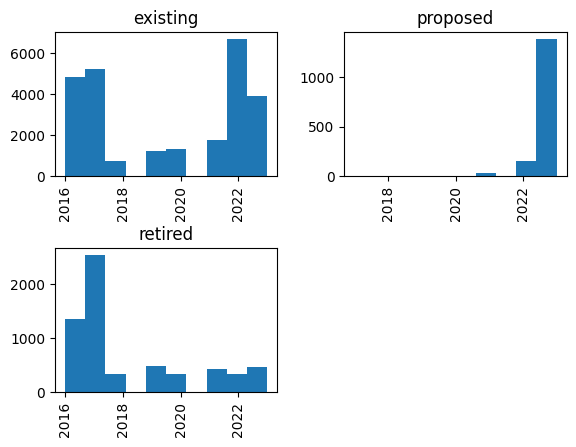

In [37]:
# when was the last time most projects were updated?
pd.to_datetime(eia['report_date']).dt.year.hist(bins=10, by=eia['operational_status'])

In [38]:
eia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33617 entries, 0 to 33616
Data columns (total 25 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   report_date                               33617 non-null  object 
 1   plant_id_eia                              33617 non-null  int64  
 2   plant_name_eia                            33617 non-null  object 
 3   utility_id_eia                            33617 non-null  int64  
 4   utility_name_eia                          33617 non-null  object 
 5   generator_id                              33617 non-null  object 
 6   capacity_mw                               33617 non-null  float64
 7   state                                     33617 non-null  object 
 8   county                                    33541 non-null  object 
 9   current_planned_generator_operating_date  1581 non-null   object 
 10  energy_source_code_1              